In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from scipy import stats

In [2]:
results_folder = os.getcwd()
csv_details = "EXPERIMENTS.csv"
csv_explicit = "explicit.csv"
csv_implicit = "implicit.csv"
csv_init = "init.csv"

In [3]:
exp_details = pd.read_csv(results_folder+"/"+csv_details)
survey_explicit = pd.read_csv(results_folder+"/"+csv_explicit)
survey_implicit = pd.read_csv(results_folder+"/"+csv_implicit)
survey_init = pd.read_csv(results_folder+"/"+csv_init)

# CREATE TRUST CSV
Function successfully; Act consistently; Reliable; Predictable; Dependable; Follow directions; Meet the needs of the mission; Perform exactly as instructed; Have errors (Reverse Coded); Provide appropriate information; Unresponsive (Reverse Coded); Malfunction (Reverse Coded); Communicate with people; Provide feedback

In [ ]:
def get_trust_scores(df_survey, from_col):
    trust_scores = []
    to_col = from_col+14
    
    for index in range(len(df_survey)):
        all_values = df_survey.iloc[index].tolist()

        trust_subscale = all_values[from_col:to_col] # 14 items
        # From percentage (xx%) to float (0.xx)
        for i in range(len(trust_subscale)):
            trust_subscale[i] = float(trust_subscale[i].replace('%', 'e-2'))

        # REVERSE: Have errors (Reverse Coded); Unresponsive (Reverse Coded); Malfunction (Reverse Coded)
        for i in range(1, 4):
            trust_subscale[-i] = 1-trust_subscale[-i]

        trust_scores.append(np.round(mean(trust_subscale), 2))
        
    return trust_scores

In [ ]:
trust_init_scores = get_trust_scores(survey_init, 3)
trust_implicit_scores = get_trust_scores(survey_implicit, 1)
trust_explicit_scores = get_trust_scores(survey_explicit, 1)

# Create list of first and second surveys (explicit, implicit)
first_surveys = []
second_surveys = []
for index in np.unique(exp_details['ID']):
    order_behaviors = exp_details[exp_details['ID'] == index]['BEHAVIOR'].tolist()
    first_surveys.append(order_behaviors[0])
    second_surveys.append(order_behaviors[1])

# Create list with trust scores based on survey done
first_trust = []
second_trust = []
for i in range(len(first_surveys)):
    if first_surveys[i] == 'explicit' and second_surveys[i] == 'implicit':
        first_trust.append(trust_explicit_scores[i])
        second_trust.append(trust_implicit_scores[i])
    elif first_surveys[i] == 'implicit' and second_surveys[i] == 'explicit':
        first_trust.append(trust_implicit_scores[i])
        second_trust.append(trust_explicit_scores[i])
    else:
        print("ERROR: in explicit or implicit trust sequence.")

In [ ]:
df = pd.DataFrame(np.unique(exp_details['ID']), columns = ['ID'] )
df['INIT_TRUST'] = trust_init_scores
df['FIRST_SURVEY'] = first_surveys
df['FIRST_TRUST'] = first_trust
df['SECOND_SURVEY'] = second_surveys
df['SECOND_TRUST'] = second_trust
df

In [ ]:
df.to_csv("results_trust.csv", index=False)

# ANALYSIS

In [4]:
df = pd.read_csv("results_trust.csv")
#df.drop(df[df['ID'] == 59].index, inplace=True)
df

,ID,INIT_TRUST,FIRST_SURVEY,FIRST_TRUST,SECOND_SURVEY,SECOND_TRUST
0,0,0.76,explicit,0.89,implicit,0.95
1,1,0.86,implicit,0.81,explicit,0.89
2,2,0.84,explicit,0.65,implicit,0.85
3,3,0.81,implicit,0.89,explicit,0.79
4,4,0.64,explicit,0.97,implicit,0.89
...,...,...,...,...,...,...
57,57,0.80,implicit,0.94,explicit,0.96
58,58,0.75,explicit,0.75,implicit,0.83
59,59,0.59,implicit,0.14,explicit,0.12
60,60,0.81,explicit,0.80,implicit,0.78


In [6]:
# Dataframe with sequence explicit and then implicit
df_ei = df[df['FIRST_SURVEY'] == "explicit"]
# Dataframe with sequence implicit and then explicit
df_ie = df[df['FIRST_SURVEY'] == "implicit"]

In [7]:
sections = ['INIT', 'FIRST', 'SECOND']
statistics_ei = pd.DataFrame(['INIT', 'FIRST', 'SECOND'], columns = ['TRUST'])
statistics_ie = pd.DataFrame(['INIT', 'FIRST', 'SECOND'], columns = ['TRUST'])

In [8]:
def get_statistics(statistics, df, indexes, title):
    for section in sections:
        col = df[section+"_TRUST"][indexes].tolist()            
        row = statistics[statistics['TRUST'] == section].index
        statistics.loc[row, 'MEAN_'+title] = np.round(mean(col), 2)
        statistics.loc[row, 'STD_'+title] = np.round(np.std(col), 2)

        #statistic, pvalue = stats.kstest(col_1, col_2)
        #statistics.loc[row, 'PVALUE'] = np.round(pvalue, 2)
    return statistics

In [42]:
def update_ax(df, ax, indexes_1, indexes_2, color):
    col_0 = df["INIT_TRUST"][indexes_1].tolist()
    col_1 = df["FIRST_TRUST"][indexes_1].tolist()
    col_2 = df["FIRST_TRUST"][indexes_2].tolist()
    col_3 = df["SECOND_TRUST"][indexes_2].tolist()

    ax.plot(["INIT", "FIRST"], [col_0, col_1], color+'o-')
    ax.plot(["FIRST", "SECOND"], [col_2, col_3], color+'o-') 

    for i in range(len(indexes_1)):
        plt.text(['INIT'], col_0[i], indexes_1[i], fontsize=12)
    for i in range(len(indexes_2)):
        plt.text(['SECOND'], col_3[i], indexes_2[i], fontsize=12)

color_true_pred = "g"
color_younger_pred = "b"
color_older_pred = "r"

### EXPLICIT + IMPLICIT

In [12]:
# WRONG PREDICTION SAID IN THE first PART WITH explicit BEHAVIOR
id_true_pred = [0, 4, 6, 8, 10, 14, 16, 18, 20, 24, 26, 28, 36, 40, 42, 44, 46, 50, 54]
id_younger_pred = [34, 48, 52, 56, 60]
id_older_pred = [2, 12, 22, 30, 32, 38, 58]

statistics_ei = get_statistics(statistics_ei, df_ei, id_true_pred, "TRUE")
statistics_ei = get_statistics(statistics_ei, df_ei, id_younger_pred, "YOUNGER")
statistics_ei = get_statistics(statistics_ei, df_ei, id_older_pred, "OLDER")
print("Statistics when wrong prediction was said in the FIRST part that was EXPLICIT")
statistics_ei

Statistics when wrong prediction was said in the FIRST part that was EXPLICIT


,TRUST,MEAN_TRUE,STD_TRUE,MEAN_YOUNGER,STD_YOUNGER,MEAN_OLDER,STD_OLDER
0,INIT,0.75,0.09,0.77,0.13,0.80,0.08
1,FIRST,0.88,0.11,0.83,0.12,0.73,0.05
2,SECOND,0.88,0.10,0.85,0.07,0.86,0.12


In [13]:
# WRONG PREDICTION IN THE second PART WITH implicit BEHAVIOR
id_true_pred_2 = [4, 6, 8, 10, 12, 16, 20, 24, 28, 30, 38, 40, 42, 44, 46, 50, 54, 58, 60]
id_younger_pred_2 = [0, 18, 26, 34, 36, 48, 52, 56]
id_older_pred_2 = [2, 14, 22, 32]

statistics_ei = get_statistics(statistics_ei, df_ei, id_true_pred_2, "TRUE")
statistics_ei = get_statistics(statistics_ei, df_ei, id_younger_pred_2, "YOUNGER")
statistics_ei = get_statistics(statistics_ei, df_ei, id_older_pred_2, "OLDER")
print("Statistics when wrong prediction was said in the SECOND part that was IMPLICIT")
statistics_ei
#pd.concat([statistics_ei, statistics_ei_2], axis=0)

Statistics when wrong prediction was said in the SECOND part that was IMPLICIT


,TRUST,MEAN_TRUE,STD_TRUE,MEAN_YOUNGER,STD_YOUNGER,MEAN_OLDER,STD_OLDER
0,INIT,0.77,0.09,0.75,0.10,0.77,0.14
1,FIRST,0.84,0.12,0.86,0.10,0.76,0.12
2,SECOND,0.87,0.11,0.88,0.06,0.86,0.13


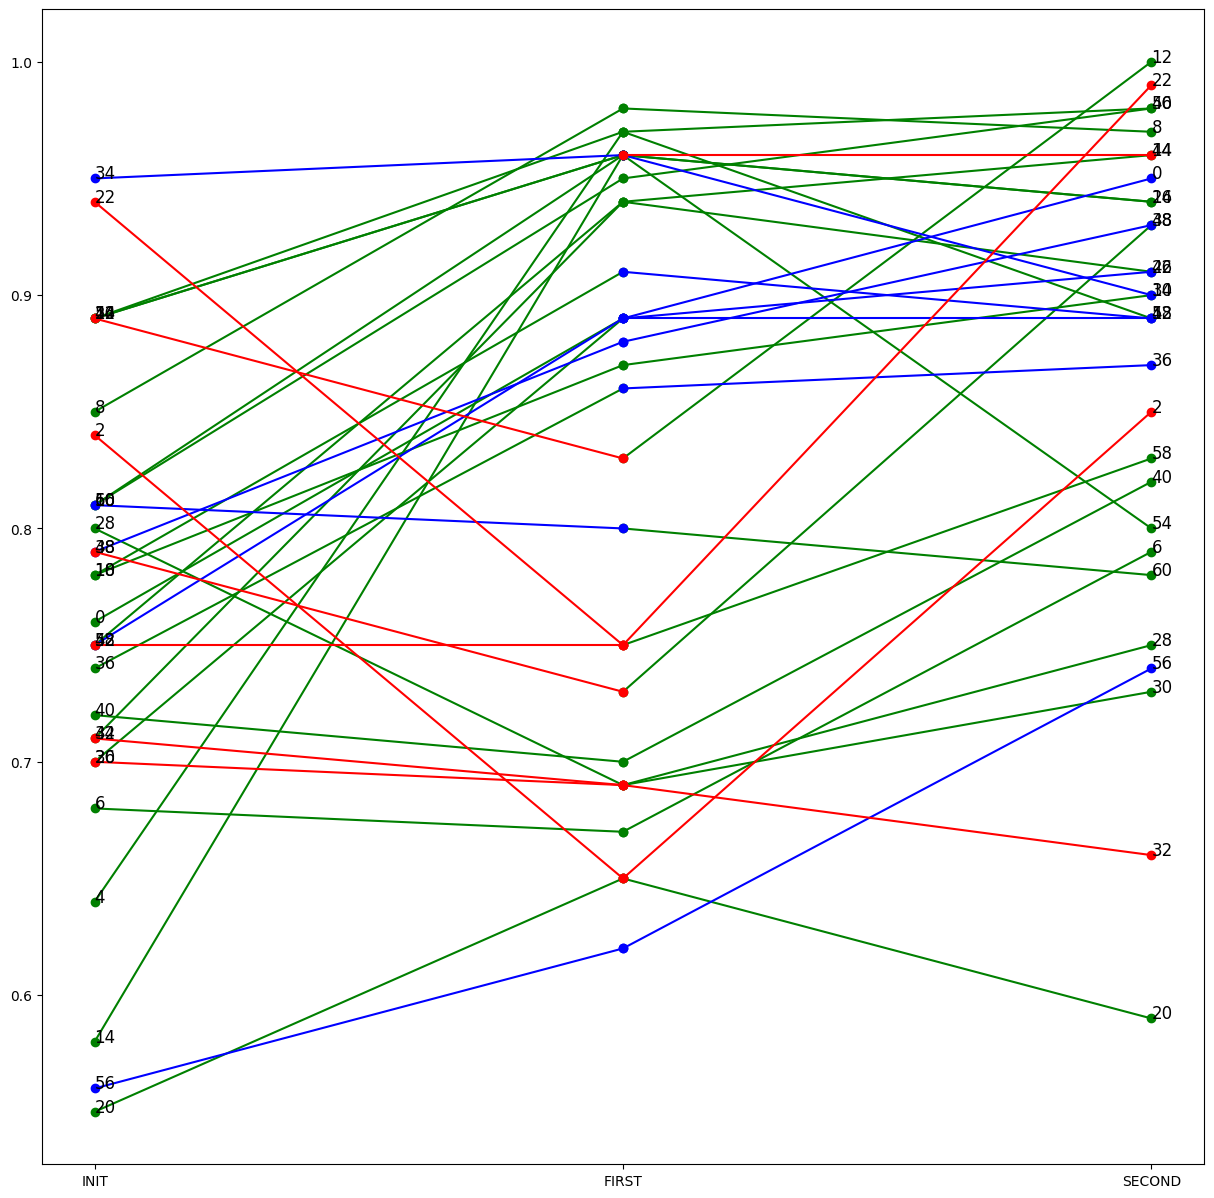

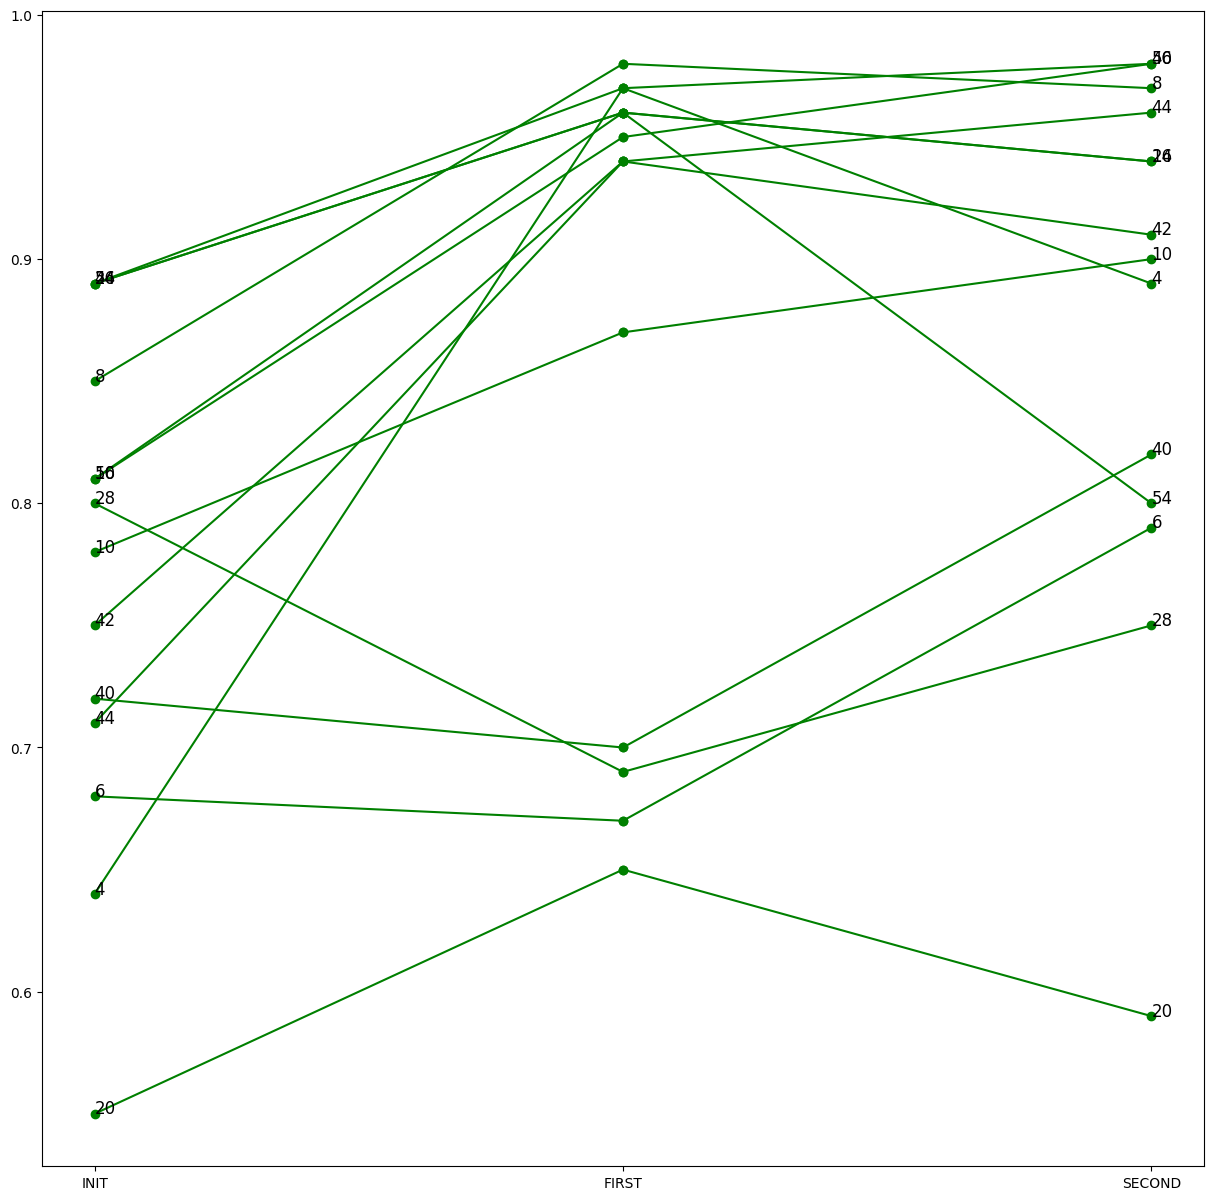

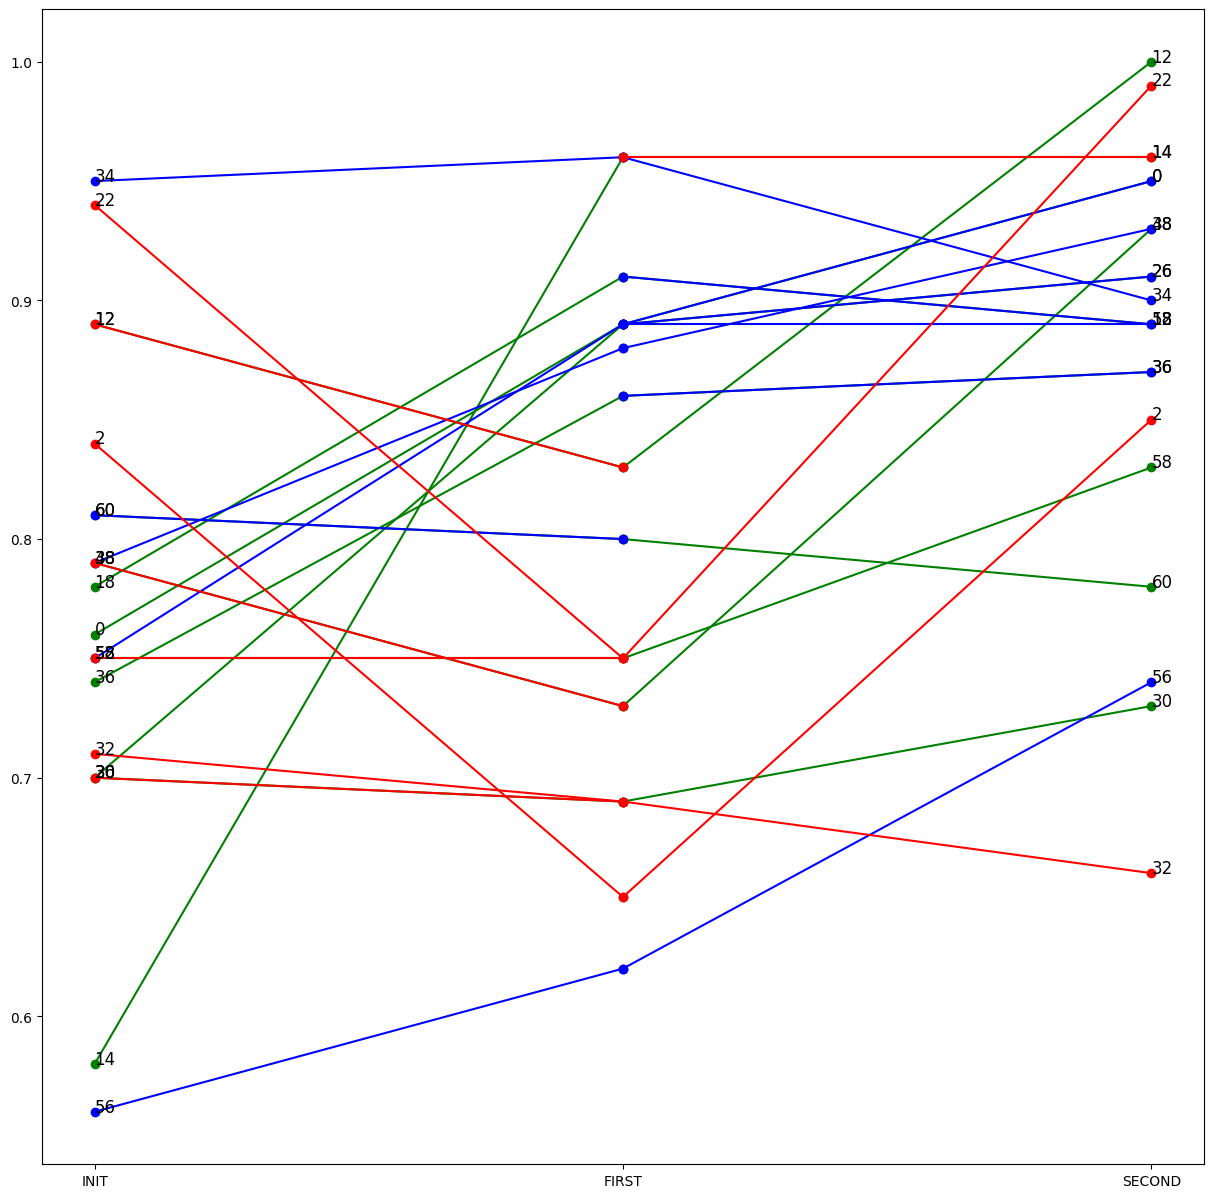

In [44]:
# ALL E+I
fig, ax = plt.subplots(1,1,figsize=(15, 15)) 

update_ax(df_ei, ax, id_true_pred, id_true_pred_2, color_true_pred)
update_ax(df_ei, ax, id_younger_pred, id_younger_pred_2, color_younger_pred)
update_ax(df_ei, ax, id_older_pred, id_older_pred_2, color_older_pred)

plt.show()

# TRUE-TRUE
fig, ax = plt.subplots(1,1,figsize=(15, 15)) 

color_true_pred = "g"
color_younger_pred = "b"
color_older_pred = "r"

id_both_true_pred = list(set(id_true_pred).intersection(set(id_true_pred_2)))

update_ax(df_ei, ax, id_both_true_pred, id_both_true_pred, color_true_pred)

plt.show()

# YOUNGER-OLDER or OLDER-YOUNGER
# TRUE-YOUNGER or YOUNGER-TRUE
# TRUE-OLDER or OLDER-TRUE
# YOUNGER-YOUNGER or OLDER-OLDER
fig, ax = plt.subplots(1,1,figsize=(15, 15)) 

id_not_both_true_pred = list(set(id_true_pred) ^ (set(id_true_pred_2)))

update_ax(df_ei, ax, id_not_both_true_pred, id_not_both_true_pred, color_true_pred)
update_ax(df_ei, ax, id_younger_pred, id_younger_pred_2, color_younger_pred)
update_ax(df_ei, ax, id_older_pred, id_older_pred_2, color_older_pred)

plt.show()

### IMPLICIT + EXPLICIT

In [45]:
# WRONG PREDICTION IN THE first PART WITH implicit BEHAVIOR
id_true_pred = [3, 5, 9, 13, 15, 17, 19, 23, 25, 31, 33, 37, 41, 43, 47, 51]
id_younger_pred = [29, 39, 45, 53, 55, 59, 61]
id_older_pred = [1, 7, 11, 21, 27, 35, 49, 57]

statistics_ie = get_statistics(statistics_ie, df_ie, id_true_pred, "TRUE")
statistics_ie = get_statistics(statistics_ie, df_ie, id_younger_pred, "YOUNGER")
statistics_ie = get_statistics(statistics_ie, df_ie, id_older_pred, "OLDER")
print("Statistics when wrong prediction was said in the FIRST part that was IMPLICIT")
statistics_ie

Statistics when wrong prediction was said in the FIRST part that was IMPLICIT


,TRUST,MEAN_TRUE,STD_TRUE,MEAN_YOUNGER,STD_YOUNGER,MEAN_OLDER,STD_OLDER
0,INIT,0.80,0.11,0.74,0.09,0.78,0.12
1,FIRST,0.87,0.08,0.74,0.26,0.81,0.16
2,SECOND,0.88,0.09,0.73,0.27,0.74,0.21


In [46]:
# WRONG PREDICTION SAID IN THE second PART WITH explicit BEHAVIOR
id_true_pred_2 = [1, 5, 9, 11, 13, 17, 19, 23, 25, 31, 33, 35, 37, 41, 43, 47, 49, 51, 57]
id_younger_pred_2 = [29, 39, 45, 53, 55, 59, 61]
id_older_pred_2 = [3, 7, 15, 21, 27]

statistics_ie = get_statistics(statistics_ie, df_ie, id_true_pred, "TRUE")
statistics_ie = get_statistics(statistics_ie, df_ie, id_younger_pred, "YOUNGER")
statistics_ie = get_statistics(statistics_ie, df_ie, id_older_pred, "OLDER")
print("Statistics when wrong prediction was said in the SECOND part that was EXPLICIT")
statistics_ie

Statistics when wrong prediction was said in the SECOND part that was EXPLICIT


,TRUST,MEAN_TRUE,STD_TRUE,MEAN_YOUNGER,STD_YOUNGER,MEAN_OLDER,STD_OLDER
0,INIT,0.80,0.11,0.74,0.09,0.78,0.12
1,FIRST,0.87,0.08,0.74,0.26,0.81,0.16
2,SECOND,0.88,0.09,0.73,0.27,0.74,0.21


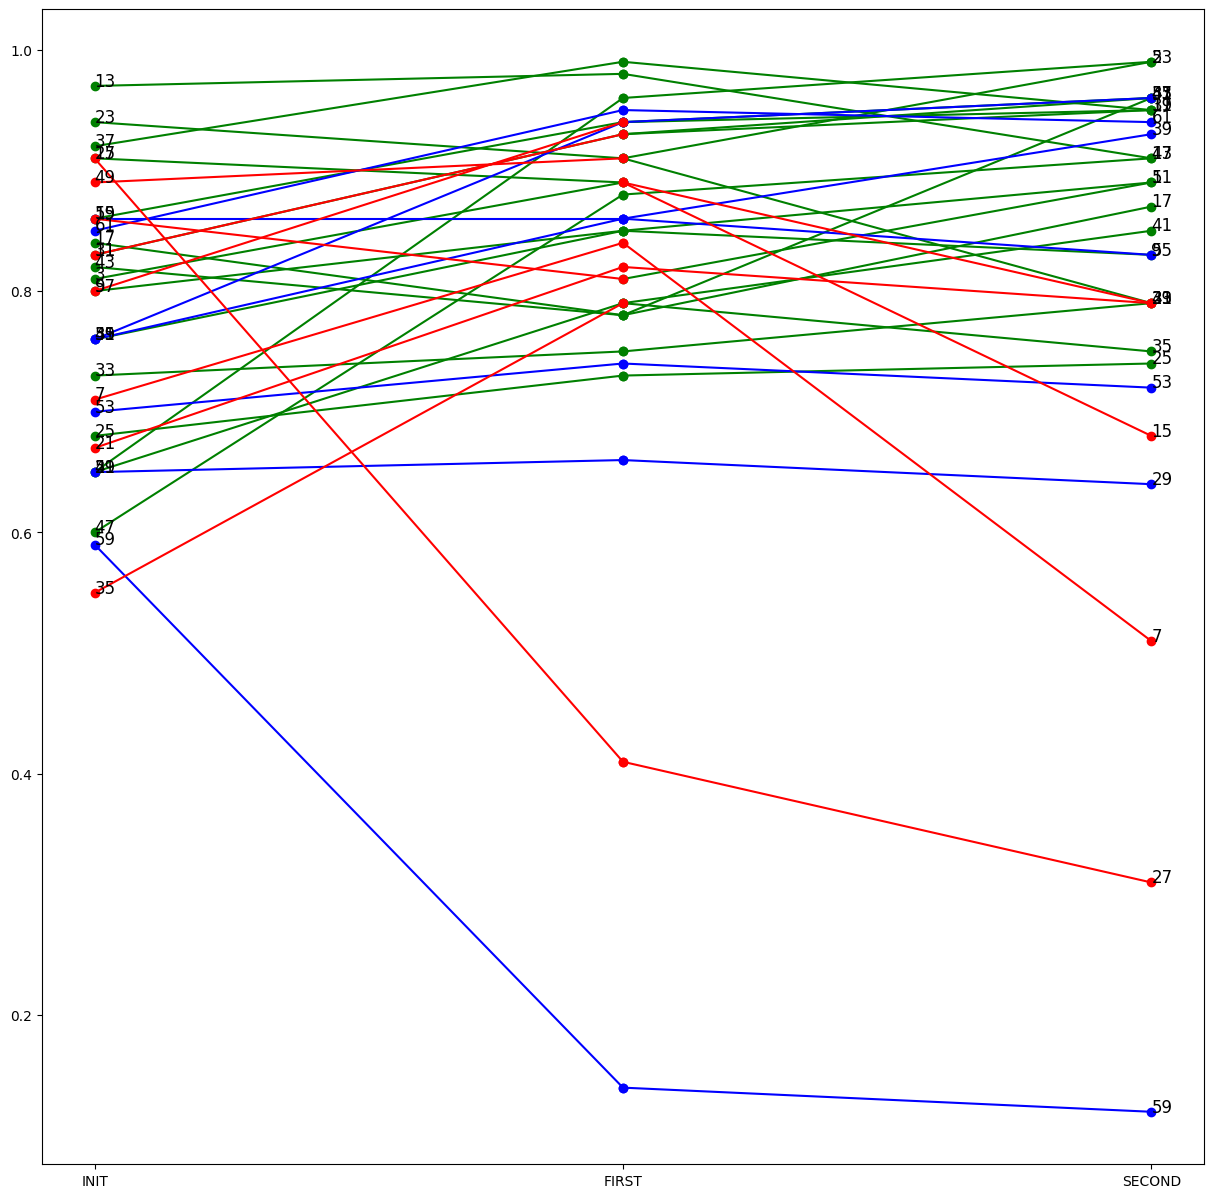

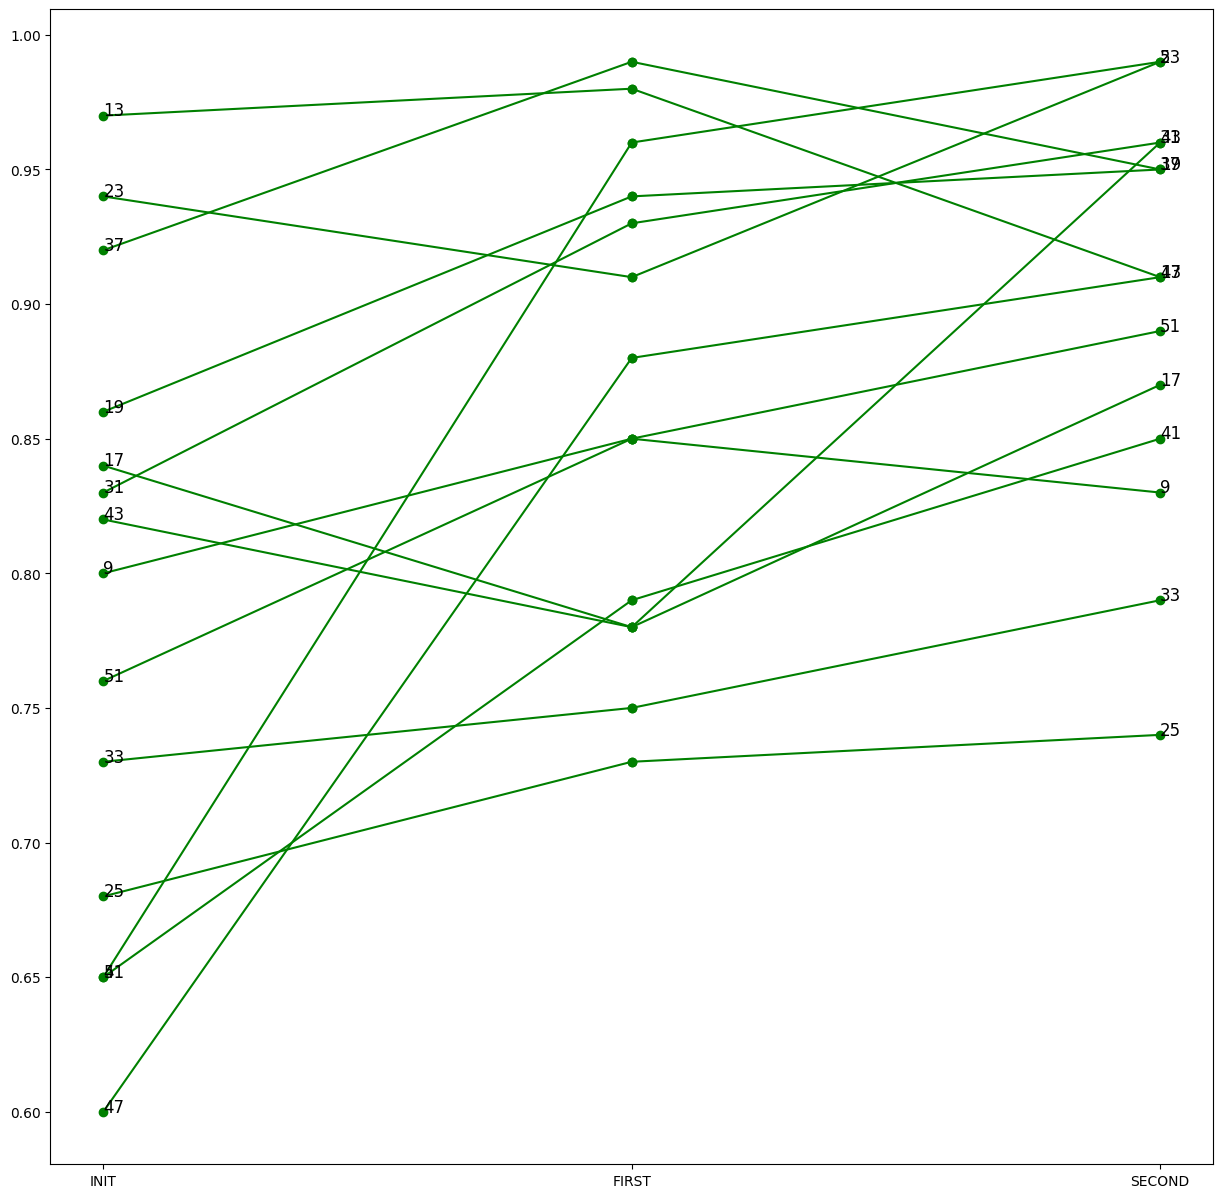

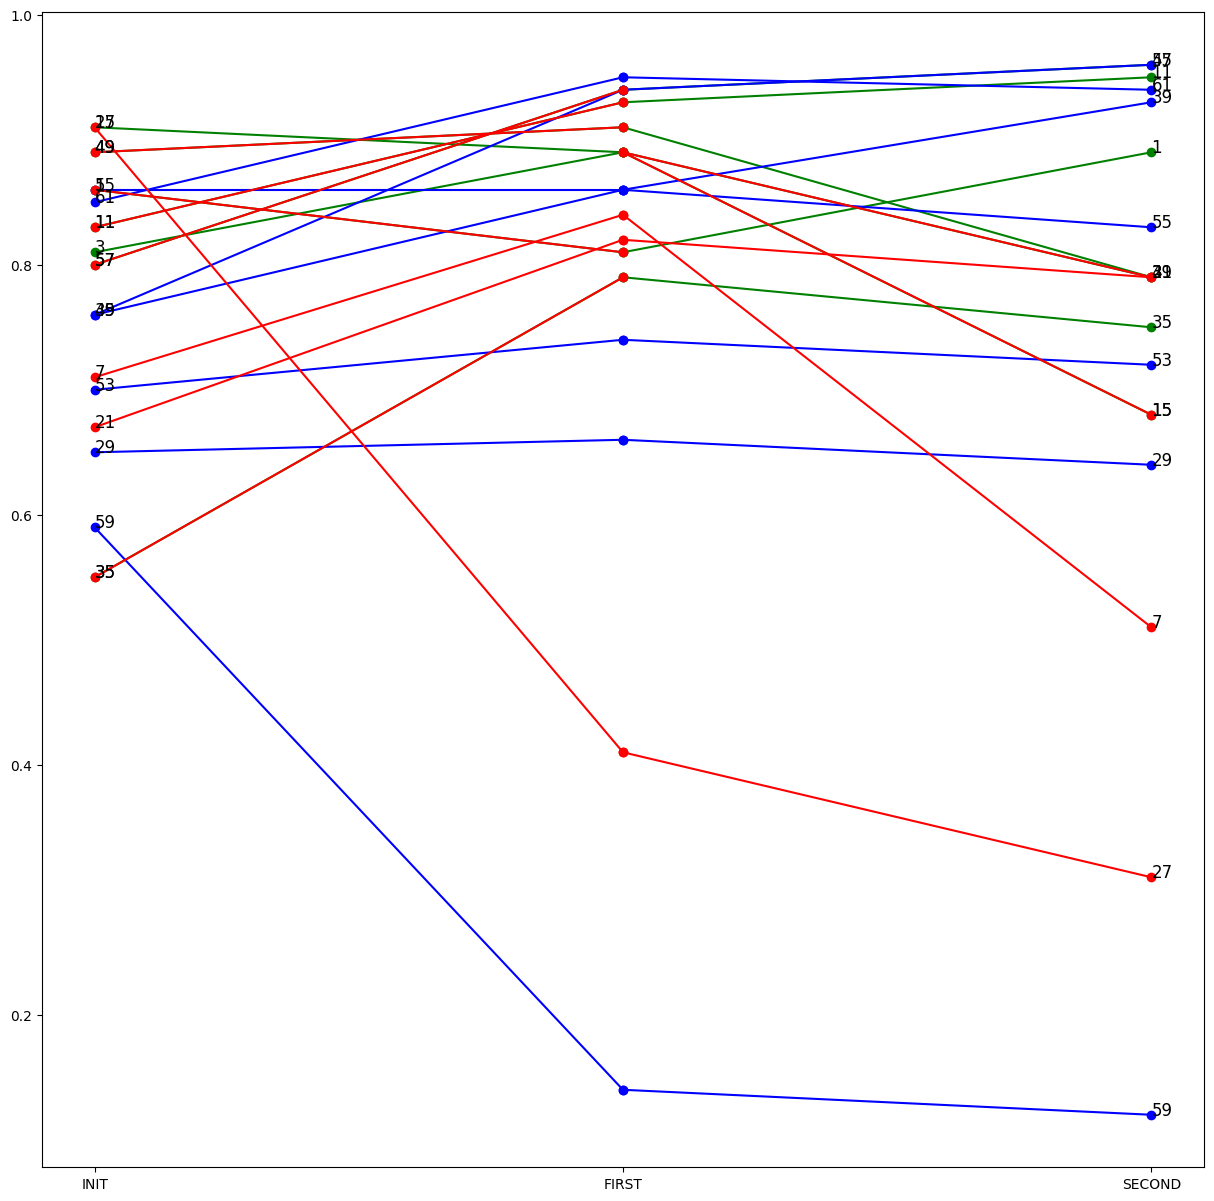

In [48]:
# ALL I+E
fig, ax = plt.subplots(1,1,figsize=(15, 15)) 

update_ax(df_ie, ax, id_true_pred, id_true_pred_2, color_true_pred)
update_ax(df_ie, ax, id_younger_pred, id_younger_pred_2, color_younger_pred)
update_ax(df_ie, ax, id_older_pred, id_older_pred_2, color_older_pred)

plt.show()

# TRUE-TRUE
fig, ax = plt.subplots(1,1,figsize=(15, 15)) 

color_true_pred = "g"
color_younger_pred = "b"
color_older_pred = "r"

id_both_true_pred = list(set(id_true_pred).intersection(set(id_true_pred_2)))

update_ax(df_ie, ax, id_both_true_pred, id_both_true_pred, color_true_pred)

plt.show()

# YOUNGER-OLDER or OLDER-YOUNGER
# TRUE-YOUNGER or YOUNGER-TRUE
# TRUE-OLDER or OLDER-TRUE
# YOUNGER-YOUNGER or OLDER-OLDER
fig, ax = plt.subplots(1,1,figsize=(15, 15)) 

id_not_both_true_pred = list(set(id_true_pred) ^ (set(id_true_pred_2)))

update_ax(df_ie, ax, id_not_both_true_pred, id_not_both_true_pred, color_true_pred)
update_ax(df_ie, ax, id_younger_pred, id_younger_pred_2, color_younger_pred)
update_ax(df_ie, ax, id_older_pred, id_older_pred_2, color_older_pred)

plt.show()

In [49]:
print("E+I")
print("INIT vs FIRST: ", stats.kstest(df_ei["INIT_TRUST"].tolist(), df_ei["FIRST_TRUST"].tolist()))
print("SECOND vs FIRST: ", stats.kstest(df_ei["SECOND_TRUST"].tolist(), df_ei["FIRST_TRUST"].tolist()))
print("I+E")
print("INIT vs FIRST: ", stats.kstest(df_ie["INIT_TRUST"].tolist(), df_ie["FIRST_TRUST"].tolist()))
print("SECOND vs FIRST: ", stats.kstest(df_ie["SECOND_TRUST"].tolist(), df_ie["FIRST_TRUST"].tolist()))

E+I
INIT vs FIRST:  KstestResult(statistic=0.3870967741935484, pvalue=0.018400608756955844)
SECOND vs FIRST:  KstestResult(statistic=0.1935483870967742, pvalue=0.615053935325554)
I+E
INIT vs FIRST:  KstestResult(statistic=0.25806451612903225, pvalue=0.2560450207654439)
SECOND vs FIRST:  KstestResult(statistic=0.16129032258064516, pvalue=0.8234535171851342)


From https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

Confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05.

INIT_TRUST is not distributed according to the FIRST_TRUST